# CH4 Time Series Forecasting
**Objective**: forecast future atmospheric methane concentration

## Input Data
- 'data/processed/ch4_preprocessed.csv'
- 'data/processed/ch4_preprocessed_logged.csv'

## Model Configuration
- 'results/CH4_full_dataset_best_model_config.json'

## Stages
1. Load the input data
2. load saved model configuration
3. log input data
4. re-fit model with saved parameters
5. rolling forecast future CH4 atmospheric concentration

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

# Load the Data

In [2]:
# load the preprocessed train and test data (from ../data/processed/), and explicity set the frequency
CH4_preprocessed = pd.read_csv(
    '../data/processed/ch4_preprocessed.csv',
    parse_dates=['date'], 
    index_col='date'
)

CH4_preprocessed.index = pd.DatetimeIndex(CH4_preprocessed.index, freq='W-SUN')

CH4_preprocessed_logged = pd.read_csv(
    '../data/processed/ch4_preprocessed_logged.csv',
    parse_dates=['date'],
    index_col='date'
)

CH4_preprocessed_logged.index = pd.DatetimeIndex(CH4_preprocessed.index, freq='W-SUN')

In [3]:
CH4_preprocessed.head()

,CH4
date,
1983-05-08,1645.17000
1983-05-15,1650.48025
1983-05-22,1650.48025
1983-05-29,1650.48025
1983-06-05,1638.08600


In [4]:
CH4_preprocessed.tail()

,CH4
date,
2025-03-09,1949.448
2025-03-16,1949.266
2025-03-23,1949.084
2025-03-30,1948.902
2025-04-06,1948.720


In [5]:
CH4_preprocessed_logged.head()

,CH4
date,
1983-05-08,7.405599
1983-05-15,7.408822
1983-05-22,7.408822
1983-05-29,7.408822
1983-06-05,7.401284


In [6]:
CH4_preprocessed_logged.tail()

,CH4
date,
2025-03-09,7.575302
2025-03-16,7.575208
2025-03-23,7.575115
2025-03-30,7.575021
2025-04-06,7.574928


# Load the model configuration and re-fit model

In [7]:
import json

with open('../results/CH4_full_dataset_best_model_config.json', 'r') as f:
    config = json.load(f)

In [8]:
# Rebuild and re-fit model
model = SARIMAX(
    CH4_preprocessed_logged,
    order=config['order'],
    seasonal_order=config['seasonal_order'],
    trend=config.get('trend', 'n'),
    enforce_stationarity=config.get('enforce_stationarity', False),
    enforce_invertibility=config.get('enforce_invertibility', False)
)

CH4_model_results = model.fit(method=config['fit_method'])

print(f"Model re-fitted using data from {config['training_date_range']['start']} to {config['training_date_range']['end']}")

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model re-fitted using data from 1983-05-08 to 2025-04-06


In [9]:
# verify the model order and seasonal order
print('"CH4_best_sarima": SARIMA(1,1,0)(1,0,2)[52]')
print('Order (p, d, q):', model.order)
print('Seasonal order (P, D, Q, s):', model.seasonal_order)

"CH4_best_sarima": SARIMA(1,1,0)(1,0,2)[52]
Order (p, d, q): (1, 1, 0)
Seasonal order (P, D, Q, s): (1, 0, 2, 52)


# Rolling forecast CH4 concentration for future periods

In [13]:
from tqdm import tqdm # for progress bars
import warnings

# Initialize variables
n_weeks = 13
rolling_forecasts = []
rolling_conf_ints = []
history = CH4_preprocessed_logged.iloc[:, 0].copy() if CH4_preprocessed_logged.ndim > 1 else CH4_preprocessed_logged.copy()
history = history.asfreq('W-SUN')

# Rolling forecast loop
for t in tqdm(range(n_weeks), desc='Generating 13-week forecast'):
    try:
        # Fit the model on the current history (suppress warnings)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            model = SARIMAX(
                history, 
                order=config['order'], 
                seasonal_order=config['seasonal_order'],
                trend=config.get('trend', 'n'),
                enforce_stationarity=config.get('enforce_stationarity', False),
                enforce_invertibility=config.get('enforce_invertibility', False)
            )
            model_fit = model.fit(method=config['fit_method'], disp=False)
    
        # Forecast one step (one week) ahead
        forecast = model_fit.get_forecast(steps=1)
        next_date = history.index[-1] + pd.Timedelta(weeks=1)

        # store the results 
        rolling_forecasts.append(
            pd.Series(
                np.exp(forecast.predicted_mean.iloc[0]),
                index=[next_date],
                name='CH4_forecast'
            )
        )
        rolling_conf_ints.append(
            pd.DataFrame(
                np.exp(forecast.conf_int().values),
                columns=['lower', 'upper'],
                index=[next_date]
            )
        )

        # update history with forecasted value (ensure that it remains 1D)
        new_value = pd.Series(
            forecast.predicted_mean.iloc[0],
            index=[next_date],
            name=history.name
        )
        history = pd.concat([history, new_value]).asfreq('W-SUN')

    except Exception as e:
        print(f'Error at week {t}: {str(e)}')
        break

# combine results
rolling_forecast = pd.concat(rolling_forecasts)
rolling_conf_int = pd.concat(rolling_conf_ints)

# save the results
rolling_forecast.to_csv('../results/13week_rolling_forecast.csv')
rolling_conf_int.to_csv('../results/13_week_rolling_conf_int.csv')

print(f'\nSuccessfully completed rolling forecast')
print(rolling_forecast.tail())

Generating 13-week forecast: 100%|██████████| 13/13 [35:50<00:00, 165.40s/it]


Successfully completed rolling forecast
2025-06-08    1946.982170
2025-06-15    1946.972531
2025-06-22    1947.621476
2025-06-29    1947.476817
2025-07-06    1946.976847
Name: CH4_forecast, dtype: float64


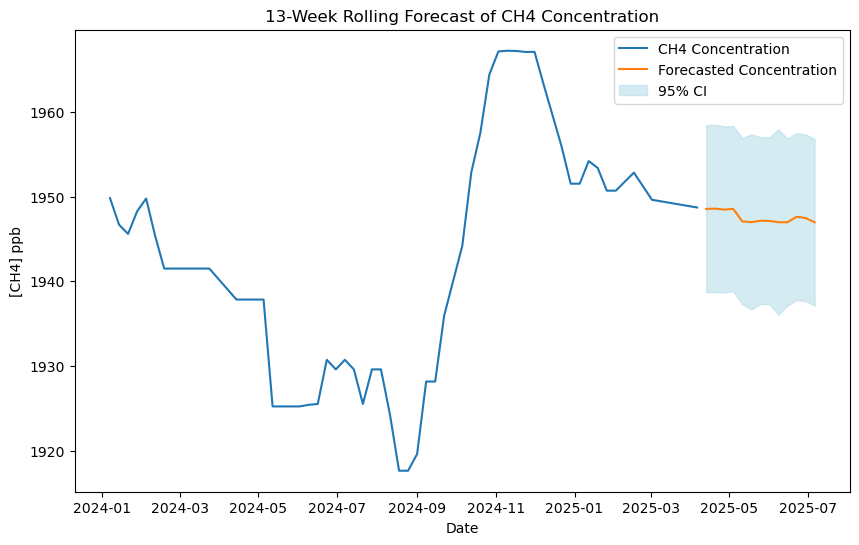

In [15]:
# visualize the forecast results

cutoff_date = pd.Timestamp('2024-01-01')
CH4_preprocessed_2024 = CH4_preprocessed[CH4_preprocessed.index >= cutoff_date]

plt.figure(figsize=(10,6))
plt.plot(CH4_preprocessed_2024.index, CH4_preprocessed_2024, label='CH4 Concentration')
plt.plot(rolling_forecast.index, rolling_forecast.values, label='Forecasted Concentration')
plt.fill_between(
    rolling_forecast.index, 
    rolling_conf_int.iloc[:, 0], 
    rolling_conf_int.iloc[:, 1], 
    color='lightblue', 
    alpha=0.5, 
    label='95% CI'
)
plt.title('13-Week Rolling Forecast of CH4 Concentration')
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.legend()
plt.show()

In [17]:
print(rolling_conf_int.columns)

Index(['lower', 'upper'], dtype='object')


In [18]:
print('Rolling 13-Week Forecast Data Table for [CH4]ppb\n')

static_forecast_table = pd.DataFrame({
    'Date': rolling_forecast.index,
    'Forecast Mean': rolling_forecast.values,
    'Lower CI': rolling_conf_int['lower'],
    'Upper CI': rolling_conf_int['upper']
})

# format the numbers
static_forecast_table[['Forecast Mean', 'Lower CI', 'Upper CI']] = (
    static_forecast_table[['Forecast Mean', 'Lower CI', 'Upper CI']].round(3)
)

print(static_forecast_table)

Rolling 13-Week Forecast Data Table for [CH4]ppb

                 Date  Forecast Mean  Lower CI  Upper CI
2025-04-13 2025-04-13       1948.551  1938.695  1958.456
2025-04-20 2025-04-20       1948.586  1938.735  1958.486
2025-04-27 2025-04-27       1948.473  1938.695  1958.301
2025-05-04 2025-05-04       1948.554  1938.816  1958.341
2025-05-11 2025-05-11       1947.080  1937.285  1956.924
2025-05-18 2025-05-18       1946.985  1936.678  1957.346
2025-05-25 2025-05-25       1947.155  1937.334  1957.027
2025-06-01 2025-06-01       1947.131  1937.312  1957.000
2025-06-08 2025-06-08       1946.982  1936.075  1957.951
2025-06-15 2025-06-15       1946.973  1937.146  1956.849
2025-06-22 2025-06-22       1947.621  1937.794  1957.499
2025-06-29 2025-06-29       1947.477  1937.662  1957.342
2025-07-06 2025-07-06       1946.977  1937.158  1956.846
